In [1]:
#imports
import torch
import copy
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import gym
from collections import deque
import os
import pandas as pd
import matplotlib.pyplot as plt
from collections import namedtuple

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


In [2]:
def plot_results(learning_rate, gamma, episode, result):

    result = np.array(result)
    
    y = [25*i for i in range(len(result))]
    y_axis = np.array(y)

    #plot graph
    plt.plot(y_axis, result)
    plt.xlabel('Number of Episodes')
    plt.ylabel('Reward')
    plt.title('Average rewards, Learning Rate: {}, Gamma: {}, Episode: {}'.format(learning_rate, gamma, episode))
    plt.show()

    pass

In [3]:
# This is the 'standard' neural network
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [4]:
class PERWithUsagePenalty:
    def __init__(self, capacity, alpha=0.8, beta_usage=0.05, epsilon = 0.05):
        """
        capacity: max number of transitions
        alpha: how strongly TD-error affects sampling probability (0 = uniform)
        beta_usage: gentle penalty factor for how often a transition has been used
        """
        self.capacity = capacity
        self.buffer = []
        self.pos = 0
        self.alpha = alpha
        self.beta_usage = beta_usage
        self.epsilon = epsilon

    def __len__(self):
        return len(self.buffer)

    def push(self, observation, action, next_observation, reward, done):
        """Add a new transition with max priority."""
        max_priority = max([t['priority'] for t in self.buffer], default=1.0)
        transition = {
            'observation': observation,
            'action': action,
            'next_observation': next_observation,
            'reward': reward,
            'done': done,
            'priority': max_priority,
            'uses': 0
        }
        if len(self.buffer) < self.capacity:
            self.buffer.append(transition)
        else:
            self.buffer[self.pos] = transition
            self.pos = (self.pos + 1) % self.capacity

    def sample(self, batch_size):
        """Sample transitions according to adjusted priority (TD-error × usage penalty)."""
        priorities = np.array([t['priority'] for t in self.buffer], dtype=np.float32)
        probs = priorities ** self.alpha
        probs /= probs.sum()
        N = len(self.buffer)
        probs = (1 - self.epsilon) * probs + self.epsilon * (1 / N)
        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        batch = [self.buffer[i] for i in indices]


        # Convert to tensors
        obs = torch.stack([t['observation'] for t in batch])
        actions = torch.tensor([t['action'] for t in batch], dtype=torch.int64).unsqueeze(1)
        rewards = torch.tensor([t['reward'] for t in batch], dtype=torch.float32).unsqueeze(1)
        next_obs = torch.stack([t['next_observation'] for t in batch])
        dones = torch.tensor([t['done'] for t in batch], dtype=torch.float32).unsqueeze(1)

        # Increment usage count (used for penalty in update)
        for t in batch:
            t['uses'] += 1

        return batch, obs, actions, rewards, next_obs, dones

    def update_td_errors(self, batch, td_errors):
        """Update priorities based on TD-error and usage penalty."""
        for transition, td_error in zip(batch, td_errors):
            td_abs = abs(td_error.item())
            # usage_penalty = 1 / (1 + self.beta_usage * transition['uses'])
            usage_penalty = np.exp(-self.beta_usage * transition['uses'])
            new_priority = td_abs * usage_penalty
            transition['priority'] = max(new_priority, 1e-5)  # avoid zero

In [5]:
def pick_action(epsilon, policy_net, env, obs):
    p = random.uniform(0,1)
    if p < epsilon:
        action = env.action_space.sample()
    else:
        if isinstance(obs, np.ndarray):
            obs = torch.tensor(obs, dtype=torch.float32)

        if obs.ndim == 1:
            obs = obs.unsqueeze(0)

        with torch.no_grad():
            q_values = policy_net(obs)
            action = torch.argmax(q_values).item()
    return action

def error(current_q, td_target, error_type):
    if error_type == "mse":
        #error = (current_q - td_target) ** 2
        compute_loss = nn.MSELoss()
        error = compute_loss(current_q, td_target)
    
    return error


In [9]:
def per_usage_DQN(
    learning_rate=0.002,
    gamma=0.99,
    episodes=2000,
    target_update=500,
    epsilon=1.0,
    capacity=50000,
    batch_size=64,
    alpha=0.6,
    beta_usage=0.05,
    epsilon_usage=0.00,
):

    env = gym.make('CartPole-v1')
    observation, _ = env.reset()
    observation = torch.tensor(observation, dtype=torch.float32)

    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    policy_net = QNetwork(state_dim, action_dim)
    target_net = QNetwork(state_dim, action_dim)
    target_net.load_state_dict(policy_net.state_dict())
    optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)

    plot_avg_rewards = []
    total_reward = 0
    step_count = 0

    # Initialize buffer
    replay_buffer = PERWithUsagePenalty(capacity=capacity, alpha=alpha, beta_usage=beta_usage, epsilon=epsilon_usage)

    for episode in range(episodes):
        observation, _ = env.reset()
        observation = torch.tensor(observation, dtype=torch.float32)
        terminated = False
        truncated = False

        # Random pole length per episode
        env.unwrapped.length = float(np.random.uniform(0.4, 1.8))

        while not terminated and not truncated:
            # Pick action
            action = pick_action(epsilon, policy_net, env, observation)
            next_observation, reward, terminated, truncated, _ = env.step(action)
            next_observation = torch.tensor(next_observation, dtype=torch.float32)
            total_reward += reward

            # Push to buffer
            replay_buffer.push(observation, action, next_observation, reward, terminated)

            # Only update if enough samples
            if len(replay_buffer) >= batch_size:
                batch, obs, a, r, obs_next, done = replay_buffer.sample(batch_size)

                # Compute TD target
                next_q_max = target_net(obs_next).max(dim=1, keepdim=True)[0].detach()
                td_target = r + gamma * (1 - done) * next_q_max

                # Compute current Q
                current_q = policy_net(obs).gather(1, a)

                # Compute loss
                loss = error(current_q, td_target, "mse")

                # Update weights
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Update learning progress in buffer
                td_errors = (td_target - current_q).detach()
                replay_buffer.update_td_errors(batch, td_errors)

            # Update target network
            if step_count % target_update == 0:
                target_net.load_state_dict(policy_net.state_dict())

            observation = next_observation
            epsilon = max(0.01, 0.995 * epsilon)
            step_count += 1

        # Logging
        if episode % 25 == 0:
            avg_reward = total_reward / 25
            plot_avg_rewards.append(avg_reward)
            total_reward = 0

        if episode % 100 == 0:
            print(f"Episode {episode}/{episodes}")

    env.close()
    os.makedirs("weights", exist_ok=True)
    torch.save(policy_net.state_dict(), "weights/PER_usage_model1.pth")

    return plot_avg_rewards, policy_net

Episode 0/500
Episode 100/500
Episode 200/500
Episode 300/500
Episode 400/500


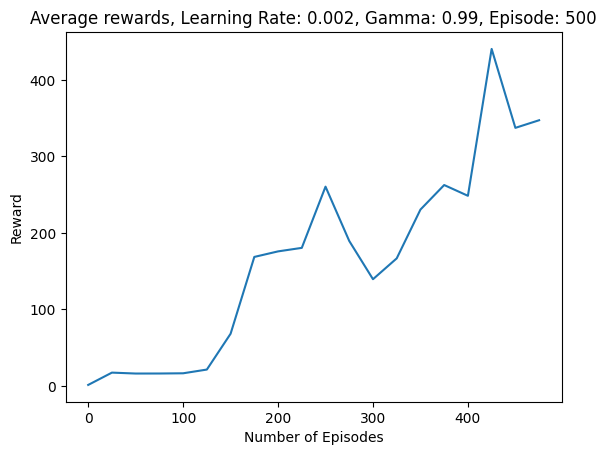

In [10]:
learning_rate = 0.002
gamma = 0.99
episodes = 500
target_update = 500
epsilon = 1
capacity = 50000
batch_size = 64
plot_avg_rewards, baseline_network = per_usage_DQN(learning_rate, gamma, episodes, target_update, epsilon, capacity, batch_size)

plot_results(learning_rate, gamma, episodes, plot_avg_rewards)

In [8]:
# import itertools
# import pandas as pd
# import numpy as np

# # Hyperparameter options
# alpha_vals = [0.6, 0.8]
# beta_vals = [0.05, 0.1]
# epsilon_vals = [0.0, 0.05]

# # Store results
# all_results = []

# # Number of runs per combination
# num_runs = 1

# for alpha, beta, eps_usage in itertools.product(alpha_vals, beta_vals, epsilon_vals):
#     run_rewards = []
#     print(f"\nTraining with alpha={alpha}, beta_usage={beta}, epsilon_usage={eps_usage}")
    
#     for run in range(num_runs):
#         print(f"  Run {run + 1}/{num_runs}")
#         plot_avg_rewards, _ = per_usage_DQN(
#             learning_rate=0.002,
#             gamma=0.99,
#             episodes=500,
#             target_update=500,
#             epsilon=1.0,
#             capacity=50000,
#             batch_size=64,
#             alpha=alpha,
#             beta_usage=beta,
#             epsilon_usage=eps_usage
#         )
#         overall_avg = sum(plot_avg_rewards) / len(plot_avg_rewards)
#         run_rewards.append(overall_avg)
    
#     # Compute mean and std over runs
#     mean_reward = np.mean(run_rewards)
#     std_reward = np.std(run_rewards)
    
#     all_results.append({
#         "alpha": alpha,
#         "beta_usage": beta,
#         "epsilon_usage": eps_usage,
#         "mean_reward": mean_reward,
#         "std_reward": std_reward
#     })
#     print(all_results)

# # Save results
# df_results = pd.DataFrame(all_results)
# df_results.to_excel("hyperparam_sweep_results.xlsx", index=False)
# print("\nHyperparameter sweep complete! Results saved to 'hyperparam_sweep_results.xlsx'.")
